In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from train import soft_net, relu_net

In [5]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
            ])),
        batch_size=1, shuffle=True)

7.9%

100.0%


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


100.0%


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw




43.7%

100.0%


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100.0%

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [14]:
device = "cpu"
epsilons = [0, .05, .1, .15, .2, .25, .3]

In [19]:
pretrained_relu = "mnist_cnn_relu.pt"
relu_model = relu_net().to(device)
relu_model.load_state_dict(torch.load(pretrained_relu, map_location='cpu'))
relu_model.eval()

relu_net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [12]:
pretrained_soft = "mnist_cnn_soft_tau=1.pt"
soft_model = soft_net(1).to(device)
soft_model.load_state_dict(torch.load(pretrained_soft, map_location='cpu'))
soft_model.eval()

soft_net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [13]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [15]:
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [16]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(soft_model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 7889 / 10000 = 0.7889
Epsilon: 0.05	Test Accuracy = 5123 / 10000 = 0.5123
Epsilon: 0.1	Test Accuracy = 2748 / 10000 = 0.2748
Epsilon: 0.15	Test Accuracy = 1363 / 10000 = 0.1363
Epsilon: 0.2	Test Accuracy = 974 / 10000 = 0.0974
Epsilon: 0.25	Test Accuracy = 898 / 10000 = 0.0898
Epsilon: 0.3	Test Accuracy = 868 / 10000 = 0.0868


In [20]:
relu_accuracies = []
relu_examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(relu_model, device, test_loader, eps)
    relu_accuracies.append(acc)
    relu_examples.append(ex)

Epsilon: 0	Test Accuracy = 8674 / 10000 = 0.8674
Epsilon: 0.05	Test Accuracy = 1065 / 10000 = 0.1065
Epsilon: 0.1	Test Accuracy = 129 / 10000 = 0.0129
Epsilon: 0.15	Test Accuracy = 39 / 10000 = 0.0039
Epsilon: 0.2	Test Accuracy = 33 / 10000 = 0.0033
Epsilon: 0.25	Test Accuracy = 40 / 10000 = 0.004
Epsilon: 0.3	Test Accuracy = 58 / 10000 = 0.0058


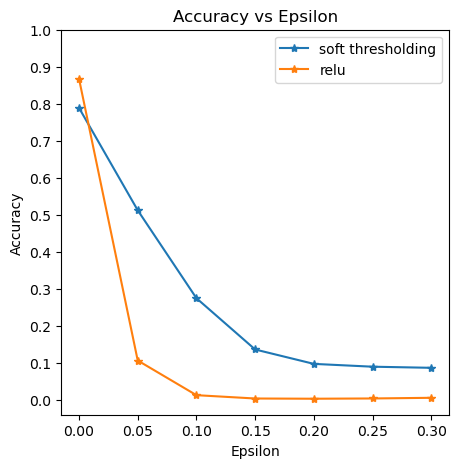

In [25]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-", label="soft thresholding")
plt.plot( epsilons, relu_accuracies, "*-", label="relu")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig( "graphs/adversarial.png")
plt.show()

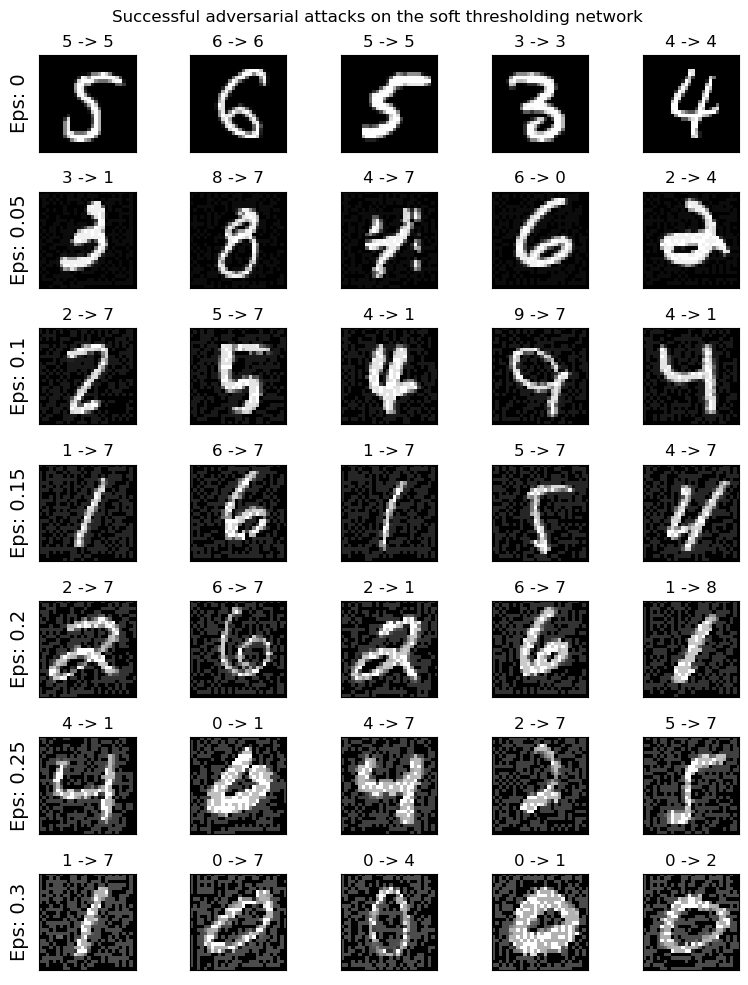

In [31]:
cnt = 0
fig = plt.figure(figsize=(8,10))
fig.suptitle( "Successful adversarial attacks on the soft thresholding network")
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.savefig( "graphs/adversarial_examples.png")
plt.show()